In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore, pearsonr
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

/var/folders/xr/psl7b1fs1m394h00dxl1r3bm0000gn/T/ipykernel_9029/282336134.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# CSV Parsing
# Load the dataset
train_data = pd.read_csv("/Users/swethashankar/Documents/VsCode/ee559/dry_bean_classification_train.csv")
test_data = pd.read_csv("/Users/swethashankar/Documents/VsCode/ee559/dry_bean_classification_test.csv")

In [3]:
train_data.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,42339,741.226,260.199330,207.306394,1.255144,0.604347,42676,232.180294,0.771202,0.992103,0.968387,0.892317,0.006146,0.002403,0.796230,0.999383,SEKER
1,68247,1088.754,370.368146,237.863792,1.557060,0.766507,70172,294.779204,0.767683,0.972567,0.723492,0.795909,0.005427,0.001343,0.633471,0.986352,BARBUNYA
2,37856,708.716,248.430330,194.360324,1.278195,0.622835,38232,219.544429,0.744640,0.990165,0.947109,0.883726,0.006563,0.002469,0.780972,0.998235,SEKER
3,33143,648.385,222.526309,189.737379,1.172812,0.522480,33377,205.423899,0.769980,0.992989,0.990685,0.923144,0.006714,0.003008,0.852195,0.999465,SEKER
4,29925,647.570,237.714031,161.004849,1.476440,0.735703,30321,195.196551,0.785309,0.986940,0.896748,0.821140,0.007944,0.002228,0.674271,0.995521,DERMASON


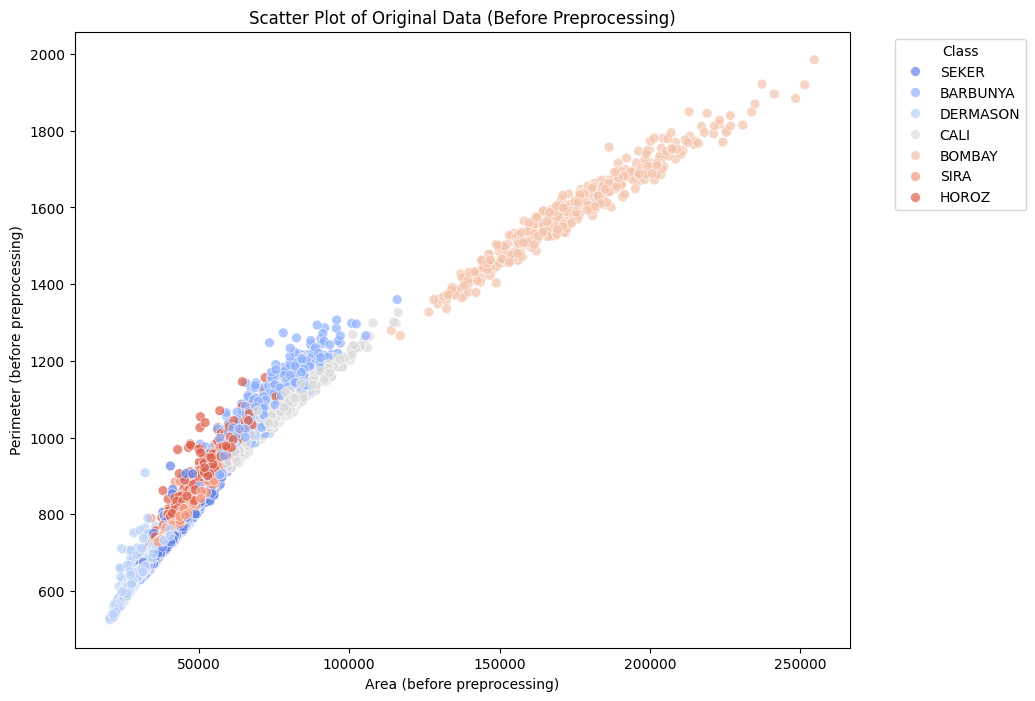

In [4]:
# Scatter plot to visualize original data
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=train_data['Area'], 
    y=train_data['Perimeter'],  
    hue=train_data['Class'],  
    palette='coolwarm',  
    s=50, 
    alpha=0.7  
)

plt.xlabel("Area (before preprocessing)")
plt.ylabel("Perimeter (before preprocessing)")
plt.title("Scatter Plot of Original Data (Before Preprocessing)")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [5]:
# Imputation and Outlier Removal
# SimpleImputer to fill missing values with the median
imputer = SimpleImputer(strategy='median')

# Apply the imputer to numeric features
numeric_features = train_data.select_dtypes(include=[np.number])
train_data[numeric_features.columns] = imputer.fit_transform(numeric_features)

# # Remove outliers using z-score (3 standard deviations)
z_scores = np.abs(train_data.select_dtypes(include=[np.number]).apply(zscore))
train_data = train_data[(z_scores < 3).all(axis=1)]

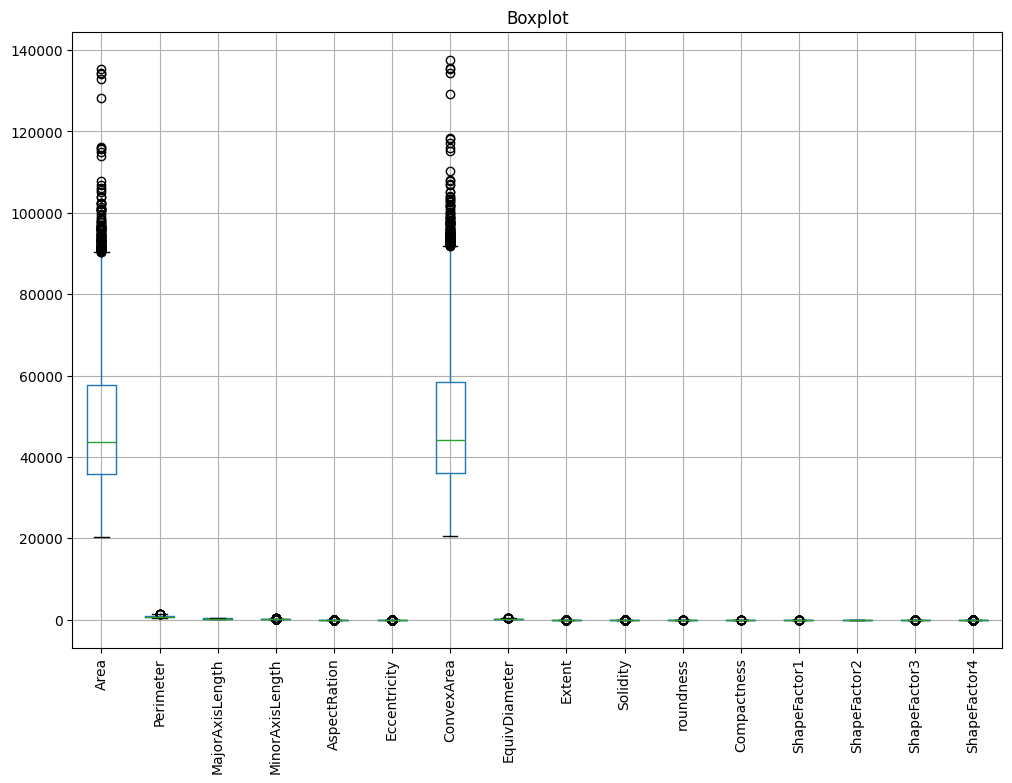

In [6]:
# Boxplot Visualization
train_data.boxplot(figsize=(12, 8))
plt.xticks(rotation=90)
plt.title("Boxplot")
plt.show()

In [7]:
# LabelEncoder to transform class labels into numerical values
label_encoder = LabelEncoder()
train_data['Class'] = label_encoder.fit_transform(train_data['Class'])
test_data['Class'] = label_encoder.transform(test_data['Class'])

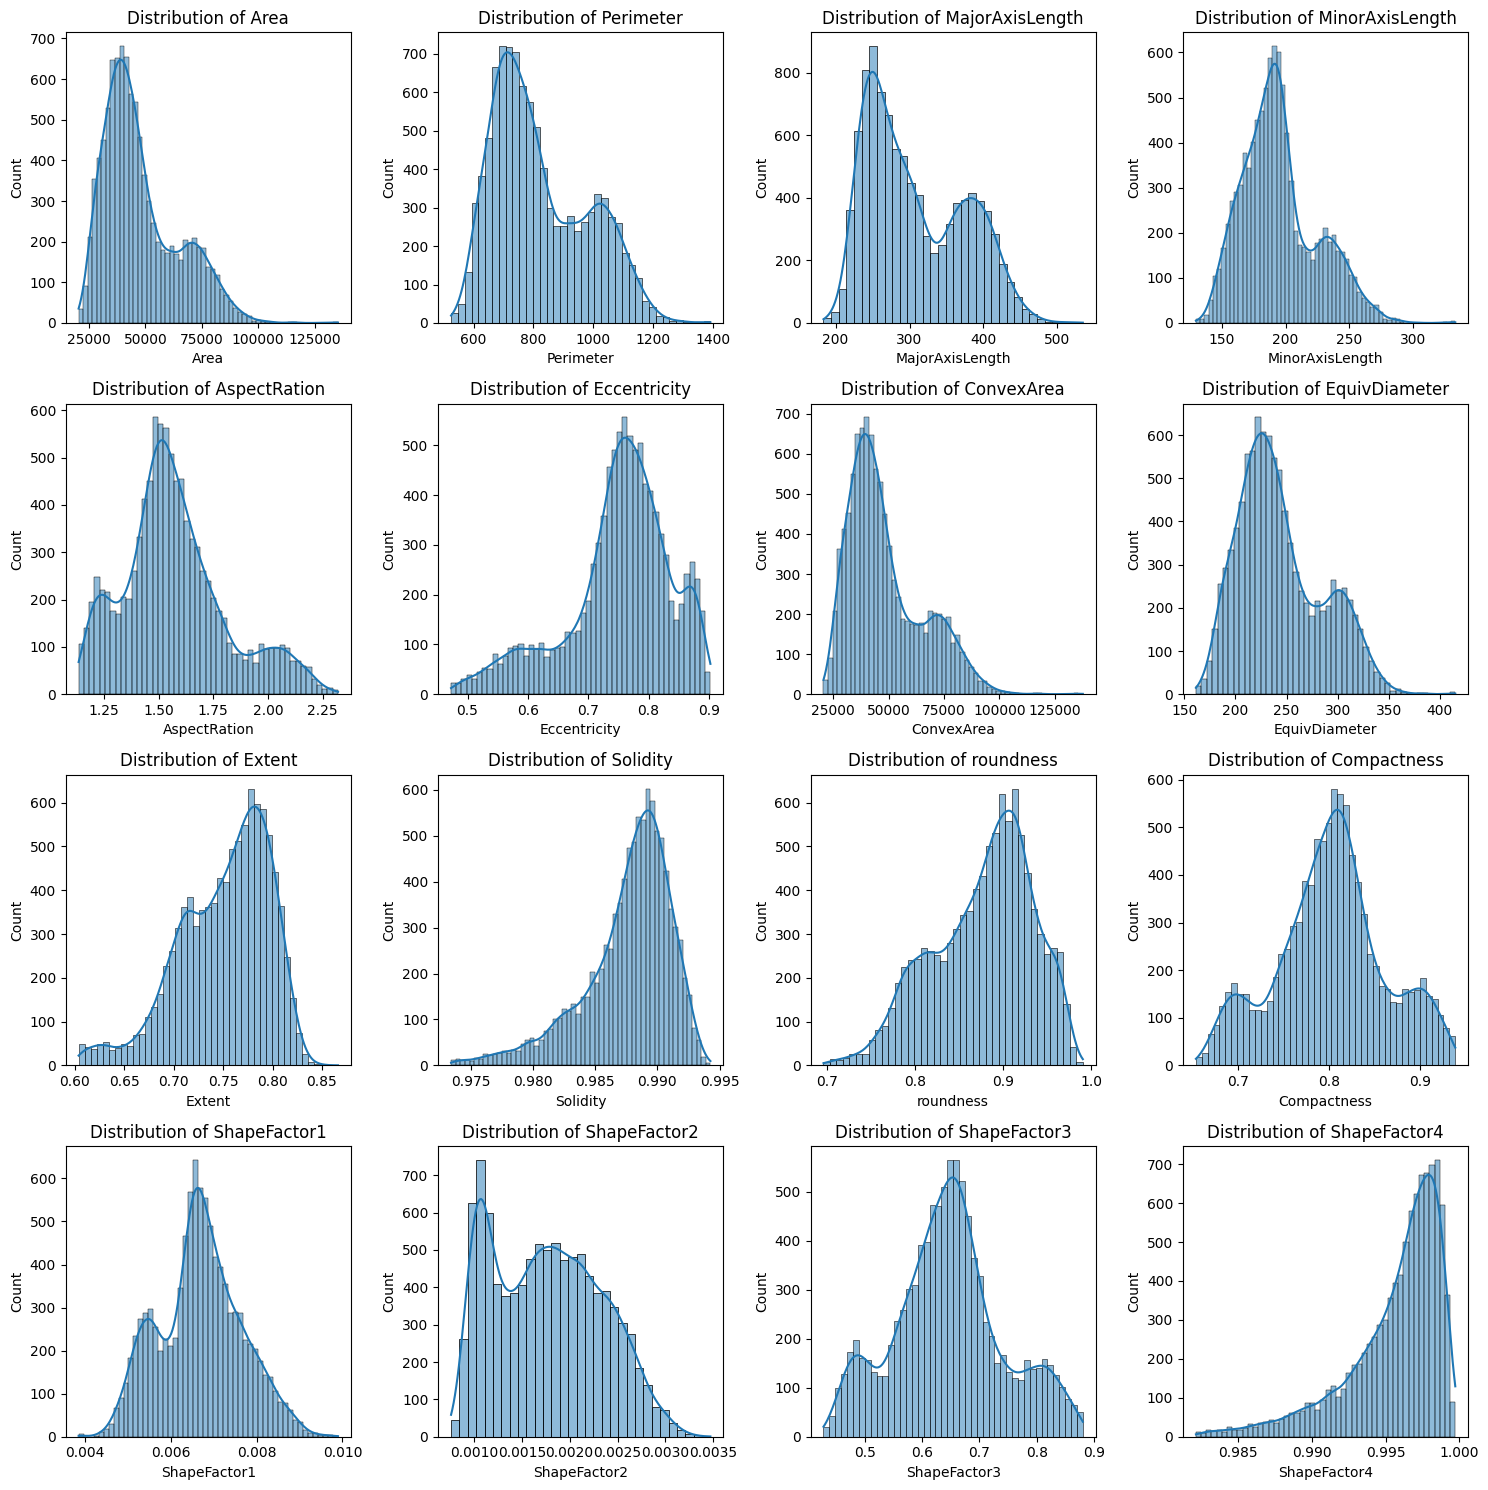

In [8]:
# Histograms for numerical features
numerical_features = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

plt.figure(figsize=(15, 15))
for idx, feature in enumerate(numerical_features[:-1], start=1):
    plt.subplot(4, 4, idx)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

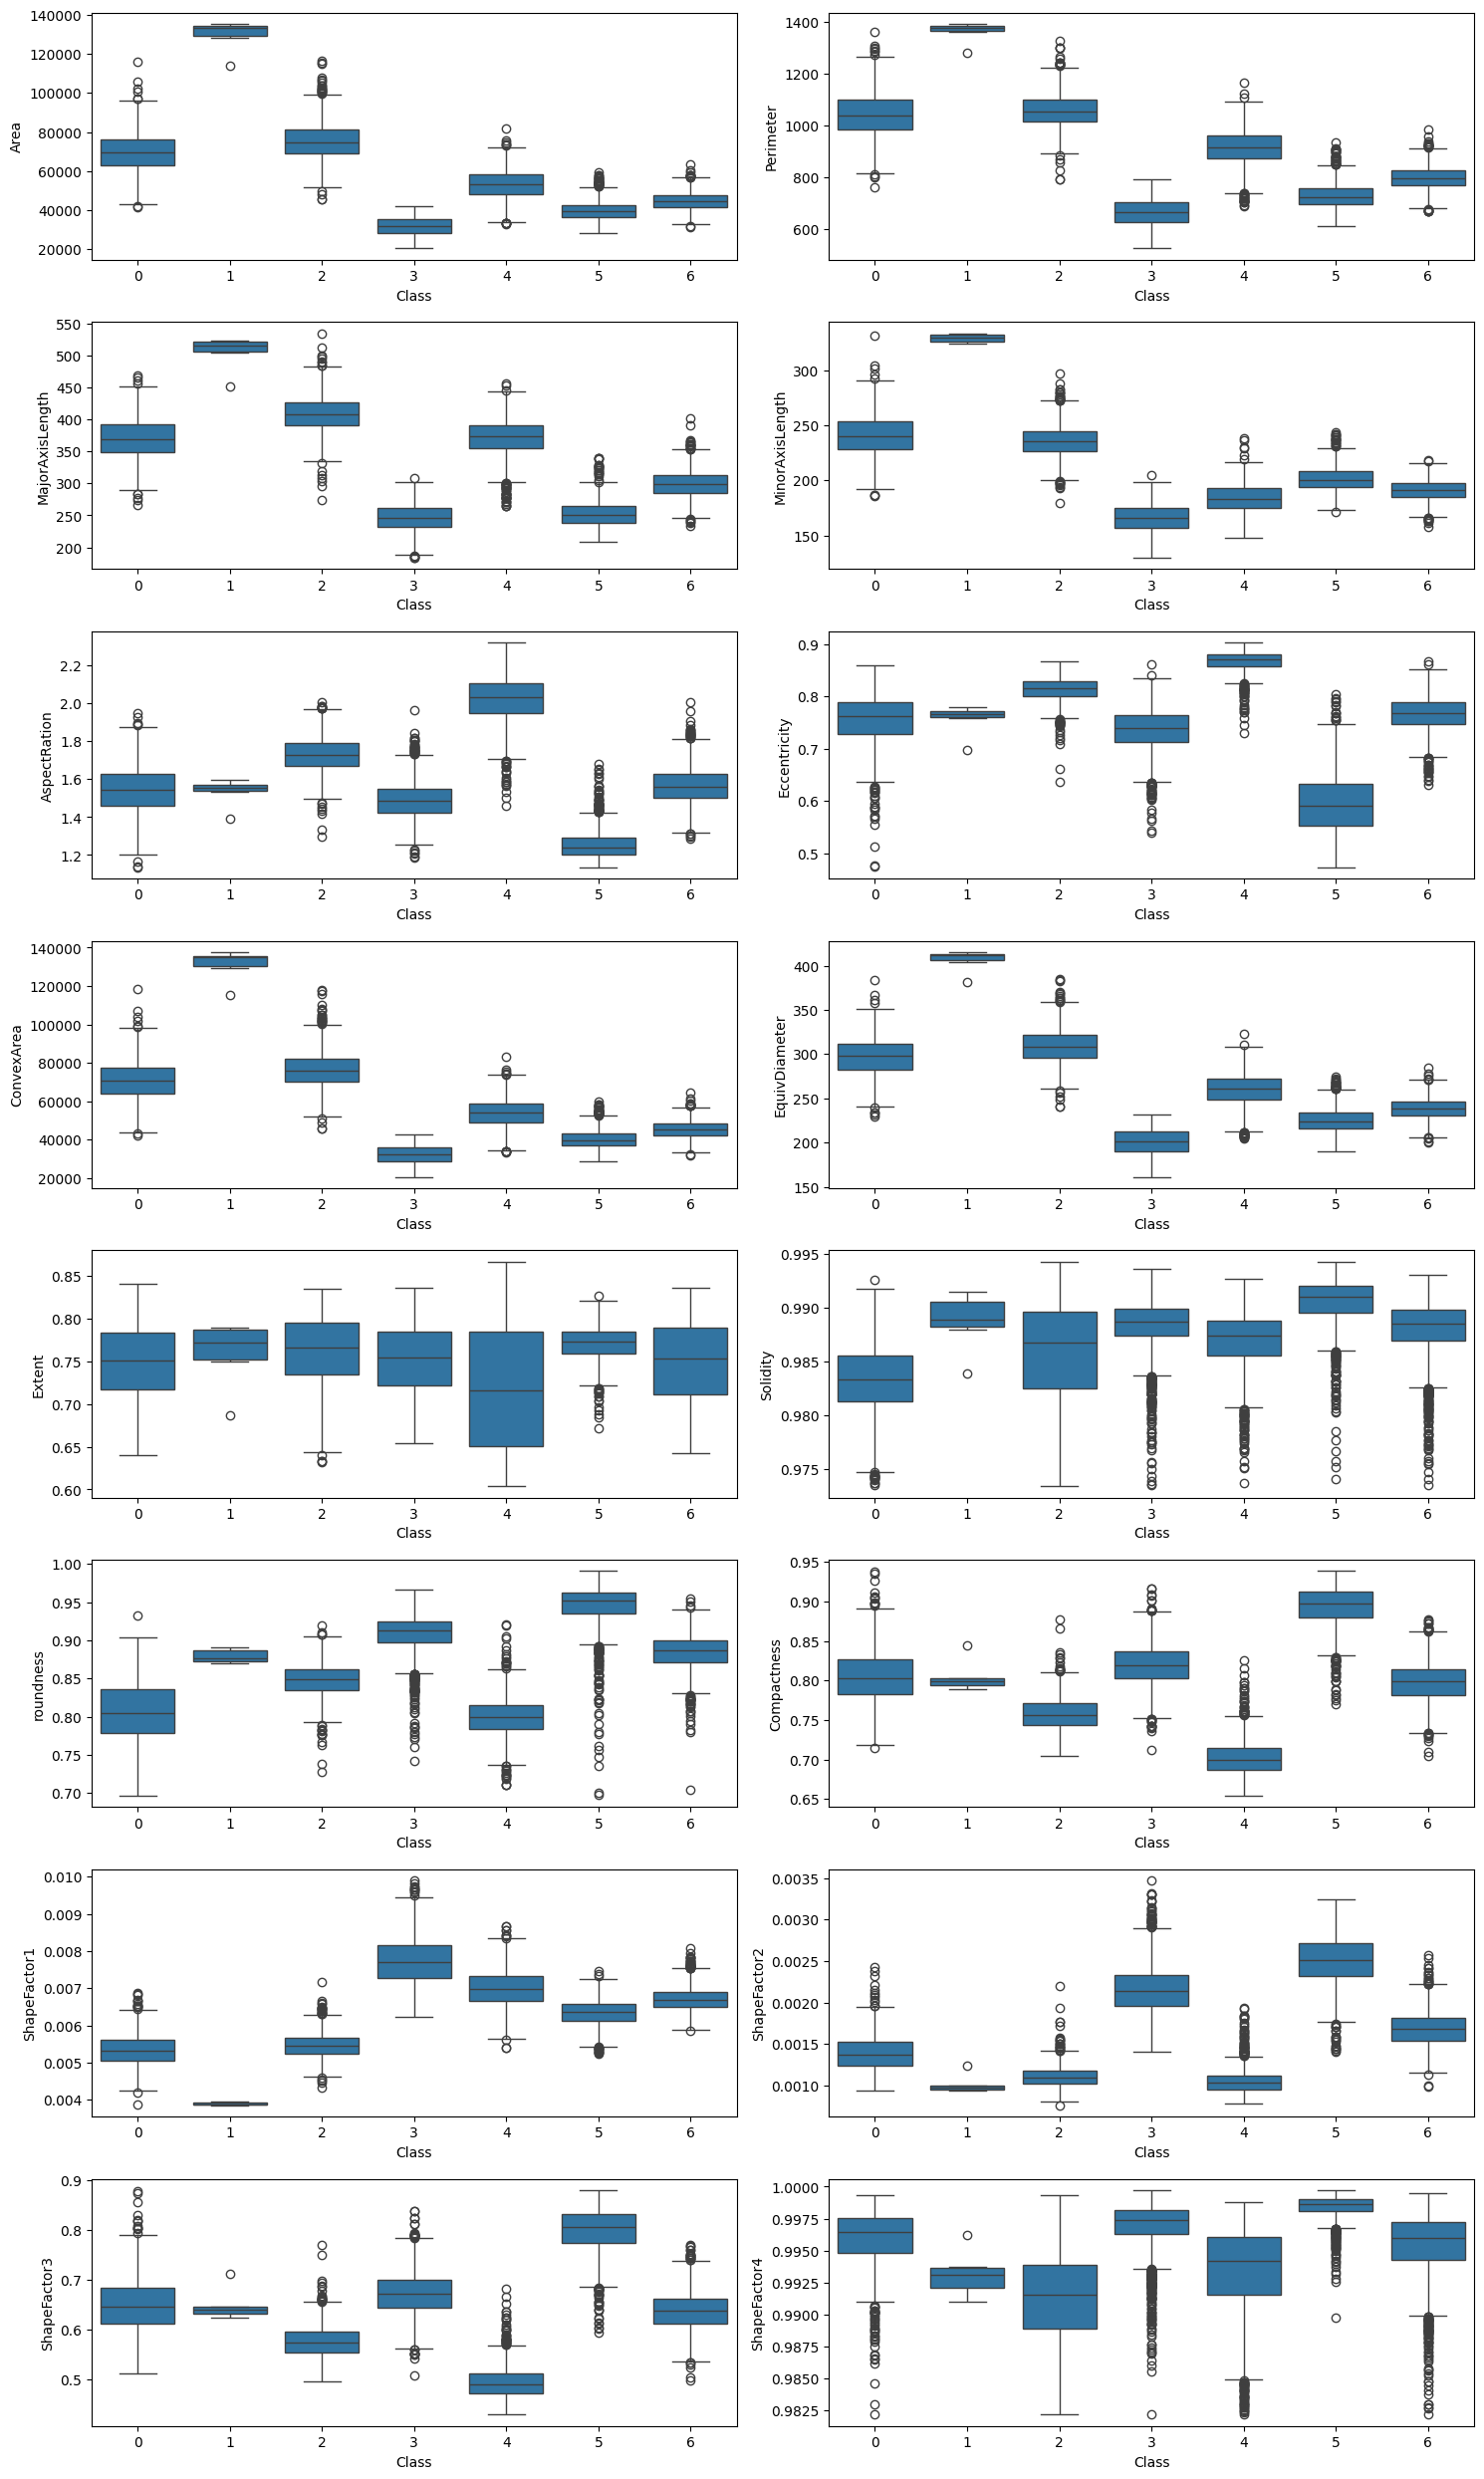

In [9]:
# Boxplot to visualize numerical features after outlier removal
fig, ax = plt.subplots(8, 2, figsize=(15, 25))

for variable, subplot in zip(numerical_features, ax.flatten()):
    sns.boxplot(x=train_data['Class'], y= train_data[variable], ax=subplot)
plt.tight_layout()

In [10]:
# Apply StandardScaler to standardize numeric features
scaler = StandardScaler()
features = train_data.columns[:-1]  # All columns except 'Class'
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data["Class"]
y_test = test_data["Class"]

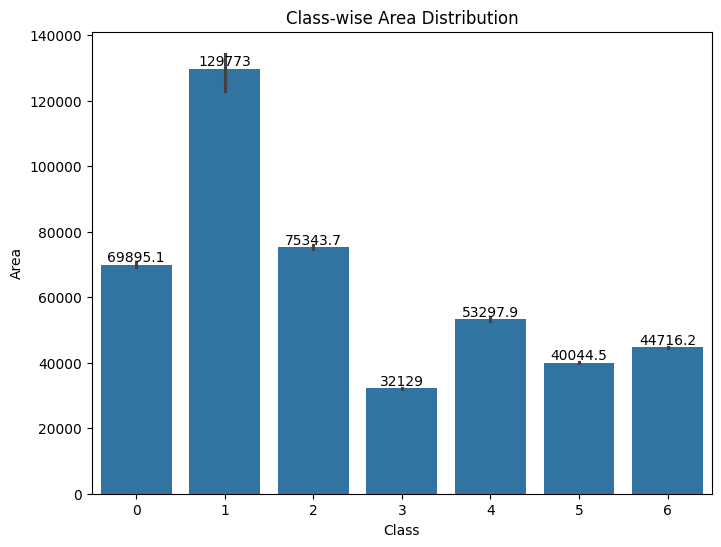

In [11]:
# Barplot Visualization
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=train_data['Class'], y=train_data['Area'])
ax.bar_label(ax.containers[0])
plt.xlabel('Class')
plt.ylabel('Area')
plt.title("Class-wise Area Distribution")
plt.show()

In [12]:
# Data Balance with SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

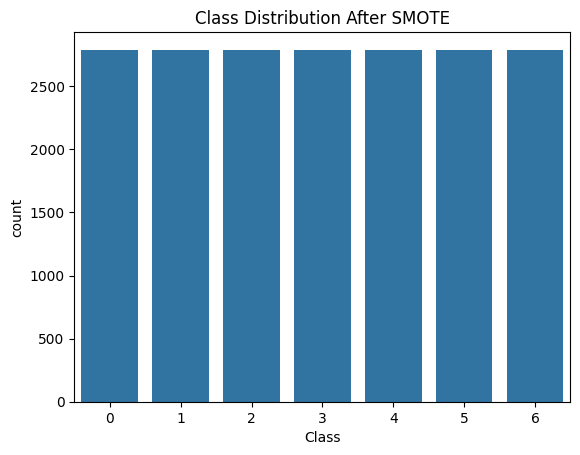

In [13]:
sns.countplot(x=y_resampled)  # y_resampled is the resampled class labels after SMOTE
plt.title("Class Distribution After SMOTE")
plt.show()

In [14]:
# Add small random noise to each feature
noise = np.random.normal(0, 0.1, X_resampled.shape)
X_resampled += noise

In [15]:
X_resampled.shape

(19523, 16)

In [16]:
# Function to add statistical aggregations
def add_statistical_aggregations(X):
    X_df = pd.DataFrame(X)  # Convert to df
    
    # Calculating statistical features
    X_df["mean"] = X_df.mean(axis=1)
    X_df["median"] = X_df.median(axis=1)
    X_df["std"] = X_df.std(axis=1)
    
    return X_df.values  # Return as numpy array for pipeline consistency

X_resampled_df = pd.DataFrame(X_resampled)  # Convert to df
X_resampled_df.columns = X_resampled_df.columns.astype(str)  # Convert all feature names to strings

# Interaction terms, log transformation and feature expansion
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
log_transformer = FunctionTransformer(np.log1p, validate=True)
stat_aggregations = FunctionTransformer(lambda X: add_statistical_aggregations(X), validate=False)

# From [https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html]
# Pipeline with interaction terms, log transform, and scaling
feature_pipeline = Pipeline([
    ('interactions', interaction),
    ('log_transform', log_transformer),
    ('stat_aggregations', stat_aggregations),
    ('scaler', StandardScaler())  # Apply standardization
])

# Applying the pipeline to expand the feature space
X_resampled_transformed = feature_pipeline.fit_transform(X_resampled_df) 
X_test_transformed = feature_pipeline.transform(X_test)

# from [https://numpy.org/doc/stable/reference/generated/numpy.issubdtype.html]
# Function to remove infs and NaNs
def remove_infs_and_nans(data):
    if np.issubdtype(data.dtype, np.number):
        data[np.isinf(data)] = np.nan
        return np.nan_to_num(data, nan=0.0)  # Replace NaNs with neutral value
    return data

# Clean transformed data and ensure consistency
X_resampled_transformed = remove_infs_and_nans(X_resampled_transformed)
X_test_transformed = remove_infs_and_nans(X_test_transformed)

# Applying the cleaning function to y_resampled
y_resampled = remove_infs_and_nans(y_resampled)
y_test = remove_infs_and_nans(y_test)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:348: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:348: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))
/var/folders/xr/psl7b1fs1m394h00dxl1r3bm0000gn/T/ipykernel_9029/1873544527.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

/var/folders/xr/psl7b1fs1m394h00dxl1r3bm0000gn/T/ipykernel_9029/1367143436.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


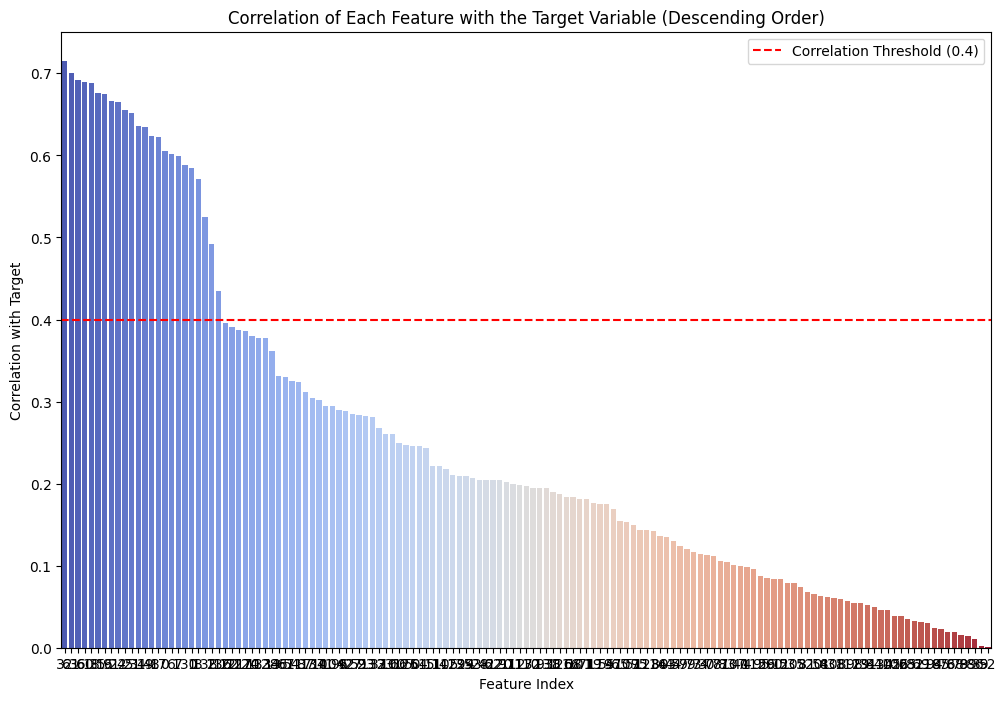

Number of features selected with correlation > 0.4: 24


In [17]:
# Calculate Pearson correlations between each feature and the target variable
correlations = {}
for i, feature in enumerate(X_resampled_transformed.T):
    corr, _ = pearsonr(feature, y_resampled)
    correlations[i] = abs(corr)  # Use absolute values to avoid negative correlations

# Create a df and sort by correlation in descending order
correlation_df = pd.DataFrame(list(correlations.items()), columns=["Feature Index", "Correlation with Target"])
correlation_df = correlation_df.sort_values(by="Correlation with Target", ascending=False)

# Create a bar plot with features in descending order of correlation
plt.figure(figsize=(12, 8))
sns.barplot(
    x=correlation_df["Feature Index"],  
    y=correlation_df["Correlation with Target"], 
    order=correlation_df["Feature Index"], 
    palette='coolwarm'
)

# A threshold line for reference
correlation_threshold = 0.4
plt.axhline(y=correlation_threshold, color='r', linestyle='--', label=f"Correlation Threshold ({correlation_threshold})")

plt.xlabel("Feature Index")
plt.ylabel("Correlation with Target")
plt.title("Correlation of Each Feature with the Target Variable (Descending Order)")
plt.legend()
plt.show()

# Select features with correlation > 0.4 threshold
selected_feature_indices = correlation_df[correlation_df["Correlation with Target"] > correlation_threshold]["Feature Index"].values

# A new dataset with the selected features alone
X_selected = X_resampled_transformed[:, selected_feature_indices]
X_test_selected = X_test_transformed[:, selected_feature_indices]

print(f"Number of features selected with correlation > {correlation_threshold}: {len(selected_feature_indices)}")


In [18]:
X_test_selected.shape

(2722, 24)

In [19]:
# Function to define the Random Classifier
# Idea from [https://insidelearningmachines.com/build-a-random-forest-in-python/]
class RandomClassifier:
    def __init__(self, class_labels):
        self.class_labels = class_labels
        self.class_probs = None

    def fit(self, X, y):
        # Calculate the class distribution
        class_counts = np.bincount(y)
        total_samples = len(y)
        self.class_probs = class_counts / total_samples

    def predict(self, X):
        # Randomly sample class labels based on their probabilities
        predictions = np.random.choice(self.class_labels, size=len(X), p=self.class_probs)
        return predictions

In [20]:
# Function to plot training and validation accuracy vs epochs
def plot_accuracy_vs_epochs(train_scores, val_scores, title):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(val_scores) + 1), val_scores, 'o-', label='Validation Accuracy')
    plt.plot(range(1, len(train_scores) + 1), train_scores, 'o-', label='Training Accuracy')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training metrics
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_micro_f1 = f1_score(y_train, y_train_pred, average='micro')
    train_cm = confusion_matrix(y_train, y_train_pred)

    # Test metrics
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_micro_f1 = f1_score(y_test, y_test_pred, average='micro')
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Return results as a dictionary
    return {
        "Training Accuracy": train_acc,
        "Training Macro F1": train_macro_f1,
        "Training Micro F1": train_micro_f1,
        "Training Confusion Matrix": train_cm,
        "Test Accuracy": test_acc,
        "Test Macro F1": test_macro_f1,
        "Test Micro F1": test_micro_f1,
        "Test Confusion Matrix": test_cm
    }

In [22]:
# K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Classifier with PCA
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_selected)
X_test_pca = pca.transform(X_test_selected)

random_classifier_pca = RandomClassifier(class_labels=np.unique(y_resampled))

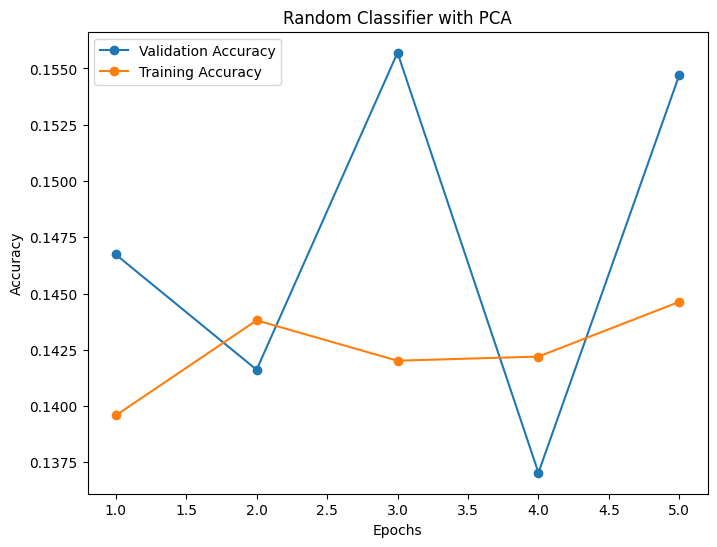

Random Classifier with PCA Results:
Training Accuracy: 0.14654510065051476
Training Macro F1: 0.14652740155284244
Training Micro F1: 0.14654510065051476
Training Confusion Matrix: [[412 411 387 365 395 398 421]
 [384 387 390 429 384 408 407]
 [420 362 408 368 419 402 410]
 [397 338 432 419 408 406 389]
 [399 394 383 409 407 413 384]
 [373 395 415 393 394 391 428]
 [390 389 390 362 417 404 437]]
Test Accuracy: 0.13629684055841293
Test Macro F1: 0.12778398700022506
Test Micro F1: 0.13629684055841293
Test Confusion Matrix: [[ 37  31  41  32  33  45  35]
 [ 23  12  14  16  14  17  12]
 [ 44  47  36  51  50  35  51]
 [ 86 124 114  94  88 115 110]
 [ 52  58  63  48  64  65  56]
 [ 64  46  67  46  68  50  55]
 [ 70  62  64  71  78  90  78]]


In [23]:
# Train and evaluate with k-fold cross-validation
train_scores = []
val_scores = []

for train_idx, val_idx in kfold.split(X_pca):
    X_train, X_val = X_pca[train_idx], X_pca[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    random_classifier_pca.fit(X_train, y_train)

    # Calculate training and validation accuracy
    train_scores.append(accuracy_score(y_train, random_classifier_pca.predict(X_train)))
    val_scores.append(accuracy_score(y_val, random_classifier_pca.predict(X_val)))

# Plot accuracy vs epochs
plot_accuracy_vs_epochs(train_scores, val_scores, "Random Classifier with PCA")

# Re-train with the best parameters
random_classifier_pca.fit(X_pca, y_resampled)

# Evaluate on test set
pca_results = evaluate_model(random_classifier_pca, X_pca, y_resampled, X_test_pca, y_test)

# Display results
print("Random Classifier with PCA Results:")
for k, v in pca_results.items():
    print(f"{k}: {v}")

In [24]:
# Random Classifier with LDA
lda = LDA(n_components=6)
X_lda = lda.fit_transform(X_selected, y_resampled)
X_test_lda = lda.transform(X_test_selected)

random_classifier_lda = RandomClassifier(class_labels=np.unique(y_resampled))

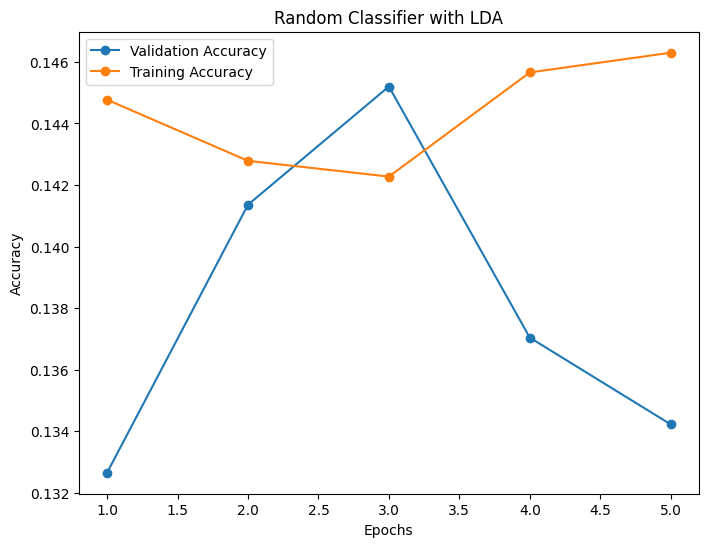

Random Classifier with LDA Results:
Training Accuracy: 0.14464990011780976
Training Macro F1: 0.14466339435995149
Training Micro F1: 0.14464990011780976
Training Confusion Matrix: [[404 381 423 397 394 373 417]
 [373 411 390 390 397 447 381]
 [374 389 375 422 383 422 424]
 [378 399 401 419 375 419 398]
 [369 418 407 391 438 378 388]
 [373 401 413 415 381 412 394]
 [442 367 422 394 393 406 365]]
Test Accuracy: 0.15062454077883908
Test Macro F1: 0.14133801915664804
Test Micro F1: 0.15062454077883908
Test Confusion Matrix: [[ 36  38  25  31  42  46  36]
 [ 14  18  11  11  18  23  13]
 [ 43  36  49  45  51  50  40]
 [109 103 105 116  98 100 100]
 [ 50  67  46  61  66  54  62]
 [ 64  52  60  63  51  48  58]
 [ 71  61  87  79  77  61  77]]


In [25]:
# Train and evaluate with k-fold cross-validation
train_scores_lda = []
val_scores_lda = []

for train_idx, val_idx in kfold.split(X_lda):
    X_train, X_val = X_lda[train_idx], X_lda[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    random_classifier_lda.fit(X_train, y_train)

    # Calculate training and validation accuracy
    train_scores_lda.append(accuracy_score(y_train, random_classifier_lda.predict(X_train)))
    val_scores_lda.append(accuracy_score(y_val, random_classifier_lda.predict(X_val)))

# Plot accuracy vs epochs
plot_accuracy_vs_epochs(train_scores_lda, val_scores_lda, "Random Classifier with LDA")

# Re-train with the best parameters
random_classifier_lda.fit(X_lda, y_resampled)

# Evaluate on test set
lda_results = evaluate_model(random_classifier_lda, X_lda, y_resampled, X_test_lda, y_test)

# Display results
print("Random Classifier with LDA Results:")
for k, v in lda_results.items():
    print(f"{k}: {v}")

In [26]:
# Function to define the Nearest Means Classifier
# From [https://github.com/ClarenceCHL/Nearest-Means-Classifier]
class NearestMeansClassifier:
    def __init__(self):
        self.class_means = None

    def fit(self, X, y):
        self.class_means = {}
        for label in np.unique(y):
            self.class_means[label] = np.mean(X[y == label], axis=0)

    def predict(self, X):
        predictions = []
        for sample in X:
            nearest_label = None
            min_distance = float('inf')
            for label, mean in self.class_means.items():
                distance = np.linalg.norm(sample - mean)
                if distance < min_distance:
                    min_distance = distance
                    nearest_label = label
            predictions.append(nearest_label)
        return np.array(predictions)

In [27]:
# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Nearest Means Classifier with PCA
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_selected)
X_test_pca = pca.transform(X_test_selected)

nearest_means_pca = NearestMeansClassifier()

In [28]:
# Train and evaluate with k-fold cross-validation
train_scores = []
val_scores = []

for train_idx, val_idx in kfold.split(X_pca):
    X_train, X_val = X_pca[train_idx], X_pca[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    nearest_means_pca.fit(X_train, y_train)

    # Calculate training and validation accuracy
    train_scores.append(accuracy_score(y_train, nearest_means_pca.predict(X_train)))
    val_scores.append(accuracy_score(y_val, nearest_means_pca.predict(X_val)))

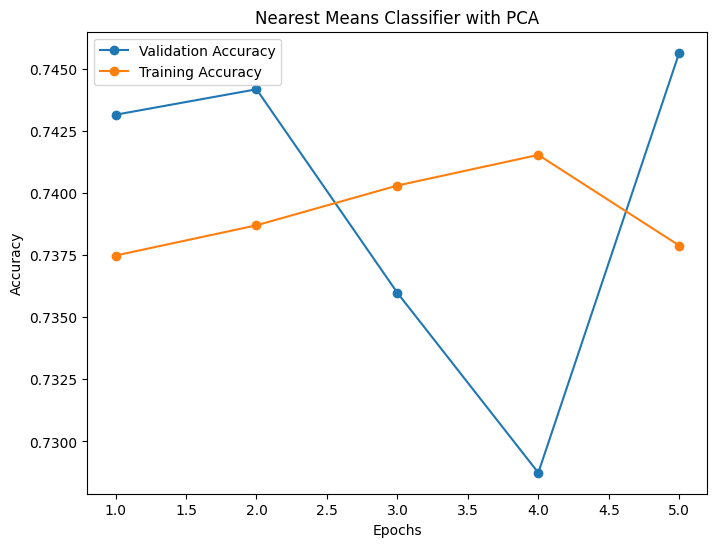

Nearest Means Classifier with PCA Results:
Training Accuracy: 0.7392818726630128
Training Macro F1: 0.7380732943721352
Training Micro F1: 0.7392818726630128
Training Confusion Matrix: [[1287   32 1013    0  200    1  256]
 [   0 2789    0    0    0    0    0]
 [ 813   81 1783    0   80    0   32]
 [ 646    0  169 1499    1  120  354]
 [ 180    0   45   21 2307   90  146]
 [   9    0    0  152   71 2220  337]
 [   2    0    0  121   70   48 2548]]
Test Accuracy: 0.6947097722263041
Test Macro F1: 0.7093999109325947
Test Micro F1: 0.6947097722263041
Test Confusion Matrix: [[109   5  98   0  13   0  29]
 [  0 108   0   0   0   0   0]
 [ 80  10 213   0   7   0   4]
 [211   0  42 342   1  27 108]
 [ 31   0  15   1 326  12  21]
 [  6   0   0  16   8 318  48]
 [  0   0   0  20  12   6 475]]


In [29]:
# Plot accuracy vs epochs
plot_accuracy_vs_epochs(train_scores, val_scores, "Nearest Means Classifier with PCA")

# Re-train with the best parameters
nearest_means_pca.fit(X_pca, y_resampled)

# Evaluate on test set
pca_results = evaluate_model(nearest_means_pca, X_pca, y_resampled, X_test_pca, y_test)

# Display results
print("Nearest Means Classifier with PCA Results:")
for k, v in pca_results.items():
    print(f"{k}: {v}")

In [30]:
# Nearest Means Classifier with LDA
lda = LDA(n_components=6)
X_lda = lda.fit_transform(X_selected, y_resampled)
X_test_lda = lda.transform(X_test_selected)

nearest_means_lda = NearestMeansClassifier()

# Train and evaluate with k-fold cross-validation
train_scores_lda = []
val_scores_lda = []

for train_idx, val_idx in kfold.split(X_lda):
    X_train, X_val = X_lda[train_idx], X_lda[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    nearest_means_lda.fit(X_train, y_train)

    # Calculate training and validation accuracy
    train_scores_lda.append(accuracy_score(y_train, nearest_means_lda.predict(X_train)))
    val_scores_lda.append(accuracy_score(y_val, nearest_means_lda.predict(X_val)))

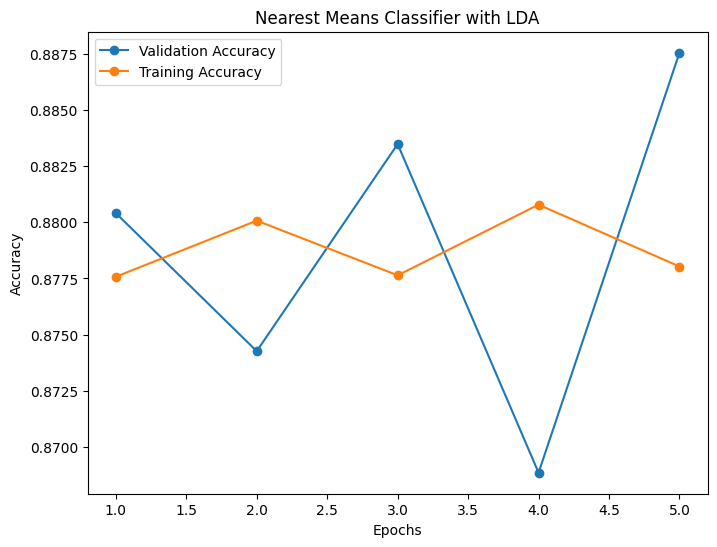

Nearest Means Classifier with LDA Results:
Training Accuracy: 0.878707165906879
Training Macro F1: 0.8795162749644359
Training Micro F1: 0.878707165906879
Training Confusion Matrix: [[2217   12  325    2    7    4  222]
 [   0 2789    0    0    0    0    0]
 [ 255   21 2410    2   26    1   74]
 [ 106    0  119 2168    2   49  345]
 [  15    0   69   26 2534   57   88]
 [   9    0    4   46   53 2477  200]
 [   3    0    4  158   40   24 2560]]
Test Accuracy: 0.8725202057310801
Test Macro F1: 0.8885688220966675
Test Micro F1: 0.8725202057310801
Test Confusion Matrix: [[198   1  26   0   1   1  27]
 [  0 108   0   0   0   0   0]
 [  5   2 297   0   2   0   8]
 [  6   0  30 581   0  11 103]
 [  0   0  16   2 367   9  12]
 [  0   0   0   7   9 352  28]
 [  0   0   1  29   9   2 472]]


In [31]:
# Plot accuracy vs epochs
plot_accuracy_vs_epochs(train_scores_lda, val_scores_lda, "Nearest Means Classifier with LDA")

# Re-train with the best parameters
nearest_means_lda.fit(X_lda, y_resampled)

# Evaluate on test set
lda_results = evaluate_model(nearest_means_lda, X_lda, y_resampled, X_test_lda, y_test)

# Display results
print("Nearest Means Classifier with LDA Results:")
for k, v in lda_results.items():
    print(f"{k}: {v}")

In [ ]:
# Thanks to Github at [https://github.com/raynaji/DiabetesPrediction/blob/master/DiabetesPrediction_GridSearchCV_LR_SVM_RF.ipynb]
# and [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html] for the following use of GridSearchCV code

In [32]:
# Define hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

In [33]:
# Function to plot training and validation accuracy vs epochs
def plot_accuracy_vs_epochs(grid_result, title):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(grid_result.cv_results_['mean_test_score']) + 1), 
             grid_result.cv_results_['mean_test_score'], 'o-', label='Validation Accuracy')
    plt.plot(range(1, len(grid_result.cv_results_['mean_train_score']) + 1), 
             grid_result.cv_results_['mean_train_score'], 'o-', label='Training Accuracy')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [34]:
# SVM with LDA
lda = LDA(n_components=6)
X_lda = lda.fit_transform(X_selected, y_resampled)
X_test_lda = lda.transform(X_test_selected)

In [35]:
# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
svm_lda = svm.SVC()

grid_lda = GridSearchCV(svm_lda, param_grid, cv=kfold, n_jobs=-1, 
                        scoring=make_scorer(accuracy_score, greater_is_better=True), 
                        return_train_score=True)

grid_lda.fit(X_lda, y_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'))

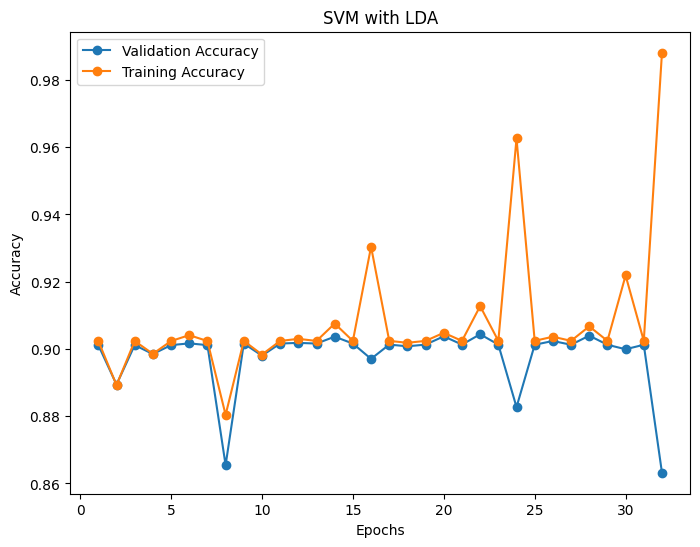

Best Hyperparameters for SVM with LDA: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVM with LDA Results:
Training Accuracy: 0.9124110024074169
Training Macro F1: 0.9125635735541462
Training Micro F1: 0.9124110024074169
Training Confusion Matrix: [[2315    0  347    0   11    6  110]
 [   0 2789    0    0    0    0    0]
 [ 243    1 2490    0   33    1   21]
 [   0    0    0 2508    4   58  219]
 [  10    0   35   25 2651   21   47]
 [   9    0    3   29   27 2600  121]
 [  16    0    8  205   60   40 2460]]
Test Accuracy: 0.8978692138133725
Test Macro F1: 0.9018338130987296
Test Micro F1: 0.8978692138133725
Test Confusion Matrix: [[207   0  28   0   2   3  14]
 [  0  91   1   0  16   0   0]
 [  6   0 299   0   6   0   3]
 [  0   0   0 646   1  12  72]
 [  0   0   7   2 387   4   6]
 [  0   0   0   7   3 368  18]
 [  3   0   3  47   9   5 446]]


In [36]:
# Plot accuracy vs epochs
plot_accuracy_vs_epochs(grid_lda, "SVM with LDA")

# Best hyperparameters
print("Best Hyperparameters for SVM with LDA:", grid_lda.best_params_)

# Re-train with the best parameters
best_svm_lda = grid_lda.best_estimator_

# Evaluate
lda_results = evaluate_model(best_svm_lda, X_lda, y_resampled, X_test_lda, y_test)

# Display results
print("SVM with LDA Results:")
for k, v in lda_results.items():
    print(f"{k}: {v}")

In [37]:
# SVM with PCA
pca = PCA(n_components=24)
X_pca = pca.fit_transform(X_selected)
X_test_pca = pca.transform(X_test_selected)

grid_pca = GridSearchCV(svm.SVC(), param_grid, cv=kfold, n_jobs=-1, 
                        scoring=make_scorer(accuracy_score, greater_is_better=True), 
                        return_train_score=True)

grid_pca.fit(X_pca, y_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'))

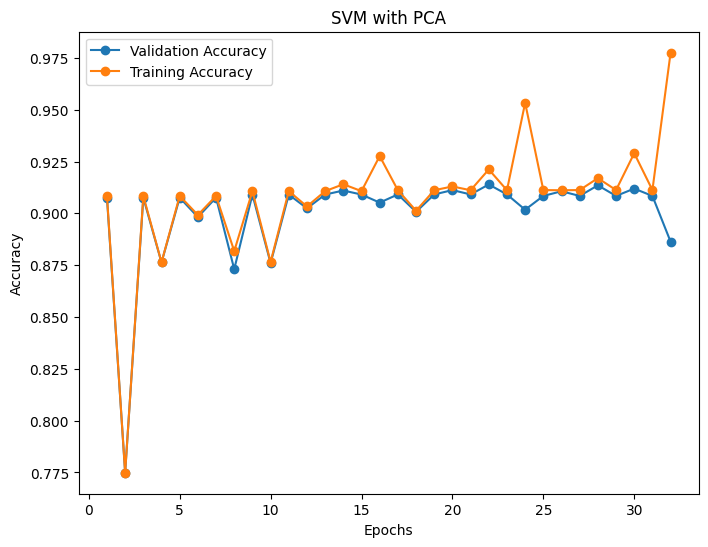

Best Hyperparameters for SVM with PCA: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVM with PCA Results:
Training Accuracy: 0.9208625723505609
Training Macro F1: 0.9210417289812597
Training Micro F1: 0.9208625723505609
Training Confusion Matrix: [[2356    0  305    0    8   13  107]
 [   0 2789    0    0    0    0    0]
 [ 223    1 2505    0   34    3   23]
 [   0    0    0 2527    5   51  206]
 [   6    0   40   14 2678    0   51]
 [  12    0    1   21    0 2650  105]
 [  19    0    7  219   35   36 2473]]
Test Accuracy: 0.881704628949302
Test Macro F1: 0.8494301041502574
Test Micro F1: 0.881704628949302
Test Confusion Matrix: [[210   0  27   0   1   3  13]
 [  0  42   1  65   0   0   0]
 [  8   0 299   0   4   0   3]
 [  0   0   0 647   4  13  67]
 [  1   0  10   2 387   0   6]
 [  1   0   0   7   0 370  18]
 [  5   0   0  46  10   7 445]]


In [38]:
# Plot accuracy vs epochs
plot_accuracy_vs_epochs(grid_pca, "SVM with PCA")

# Best hyperparameters
print("Best Hyperparameters for SVM with PCA:", grid_pca.best_params_)

# Re-train with the best parameters
best_svm_pca = grid_pca.best_estimator_

# Evaluate
pca_results = evaluate_model(best_svm_pca, X_pca, y_resampled, X_test_pca, y_test)

# Display results
print("SVM with PCA Results:")
for k, v in pca_results.items():
    print(f"{k}: {v}")

In [39]:
# Define hyperparameters
param_grid = {
    'n_neighbors': [50, 100, 150, 200, 250],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [40]:
# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Applying PCA
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_selected)
X_test_pca = pca.transform(X_test_selected)

In [41]:
# KNN with PCA
knn = KNeighborsClassifier()

grid_knn_pca = GridSearchCV(knn, param_grid, cv=kfold, n_jobs=-1, 
                            scoring=make_scorer(accuracy_score, greater_is_better=True), 
                            return_train_score=True)

grid_knn_pca.fit(X_pca, y_resampled)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [50, 100, 150, 200, 250],
                         'weights': ['uniform', 'distance']},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'))

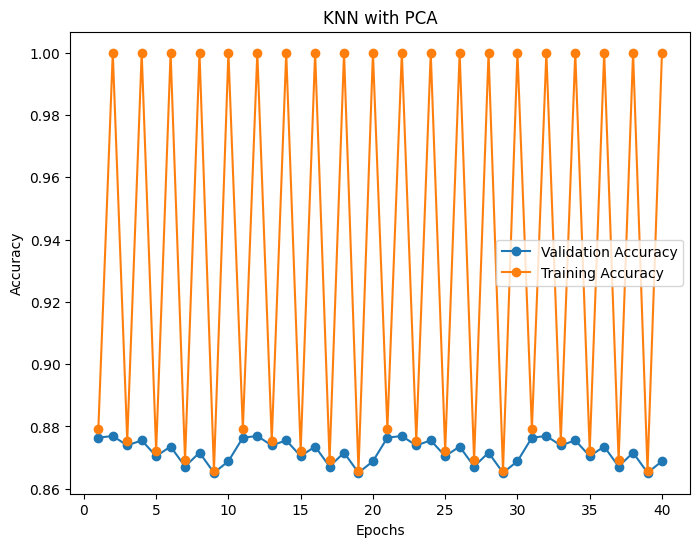

Best Hyperparameters for KNN with PCA: {'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'distance'}
KNN with PCA Results:
Training Accuracy: 1.0
Training Macro F1: 1.0
Training Micro F1: 1.0
Training Confusion Matrix: [[2789    0    0    0    0    0    0]
 [   0 2789    0    0    0    0    0]
 [   0    0 2789    0    0    0    0]
 [   0    0    0 2789    0    0    0]
 [   0    0    0    0 2789    0    0]
 [   0    0    0    0    0 2789    0]
 [   0    0    0    0    0    0 2789]]
Test Accuracy: 0.8747244673034533
Test Macro F1: 0.8767844385725068
Test Micro F1: 0.8747244673034533
Test Confusion Matrix: [[183   0  53   0   1   3  14]
 [  0 108   0   0   0   0   0]
 [ 49   1 257   0   4   0   3]
 [  0   0   1 645   1  17  67]
 [  2   0  12   2 379   5   6]
 [  2   0   0   7   2 369  16]
 [  7   0   1  46  11   8 440]]


In [42]:
# Plot accuracy vs epochs
plot_accuracy_vs_epochs(grid_knn_pca, "KNN with PCA")

# Best hyperparameters
print("Best Hyperparameters for KNN with PCA:", grid_knn_pca.best_params_)

# Re-train with the best parameters
best_knn_pca = grid_knn_pca.best_estimator_

# Evaluate
knn_pca_results = evaluate_model(best_knn_pca, X_pca, y_resampled, X_test_pca, y_test)

# Display results
print("KNN with PCA Results:")
for k, v in knn_pca_results.items():
    print(f"{k}: {v}")

In [43]:
# Applying LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_selected, y_resampled)
X_test_lda = lda.transform(X_test_selected)

# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
# KNN with LDA
knn = KNeighborsClassifier()

grid_knn_lda = GridSearchCV(knn, param_grid, cv=kfold, n_jobs=-1, 
                            scoring=make_scorer(accuracy_score, greater_is_better=True), 
                            return_train_score=True)

grid_knn_lda.fit(X_lda, y_resampled)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [50, 100, 150, 200, 250],
                         'weights': ['uniform', 'distance']},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'))

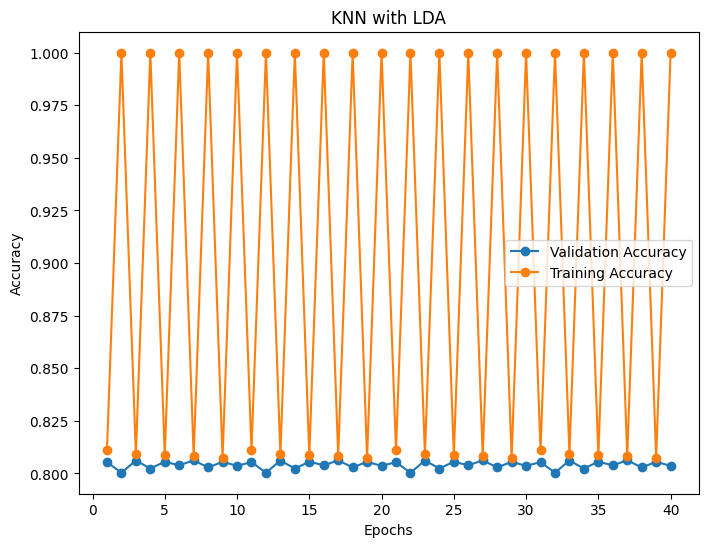

Best Hyperparameters for KNN with LDA: {'algorithm': 'auto', 'n_neighbors': 200, 'weights': 'uniform'}
KNN with LDA Results:
Training Accuracy: 0.8076627567484506
Training Macro F1: 0.8086377076407348
Training Micro F1: 0.8076627567484506
Training Confusion Matrix: [[1897    5  450  167   12   18  240]
 [   0 2789    0    0    0    0    0]
 [ 546    3 2127    7   63    3   40]
 [ 322    0    6 2055    3    9  394]
 [  19    0   50   20 2469  148   83]
 [  21    0   11   13  236 2103  405]
 [  49    0    2  216   54  140 2328]]
Test Accuracy: 0.8163115356355621
Test Macro F1: 0.8323308825969319
Test Micro F1: 0.8163115356355621
Test Confusion Matrix: [[184   0  31   7   2   2  28]
 [  0 108   0   0   0   0   0]
 [ 44   1 257   0   8   0   4]
 [ 90   0   2 526   2   2 109]
 [  0   0   6   2 382   6  10]
 [  0   0   0   3  25 315  53]
 [  3   0   0  34   9  17 450]]


In [45]:
# Plot accuracy vs epochs
plot_accuracy_vs_epochs(grid_knn_lda, "KNN with LDA")

# Best hyperparameters
print("Best Hyperparameters for KNN with LDA:", grid_knn_lda.best_params_)

# Re-train with the best parameters
best_knn_lda = grid_knn_lda.best_estimator_

# Evaluate
knn_lda_results = evaluate_model(best_knn_lda, X_lda, y_resampled, X_test_lda, y_test)

# Display results
print("KNN with LDA Results:")
for k, v in knn_lda_results.items():
    print(f"{k}: {v}")

In [46]:
# Define hyperparameters
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

In [47]:
# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# MLP with PCA
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_selected)
X_test_pca = pca.transform(X_test_selected)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

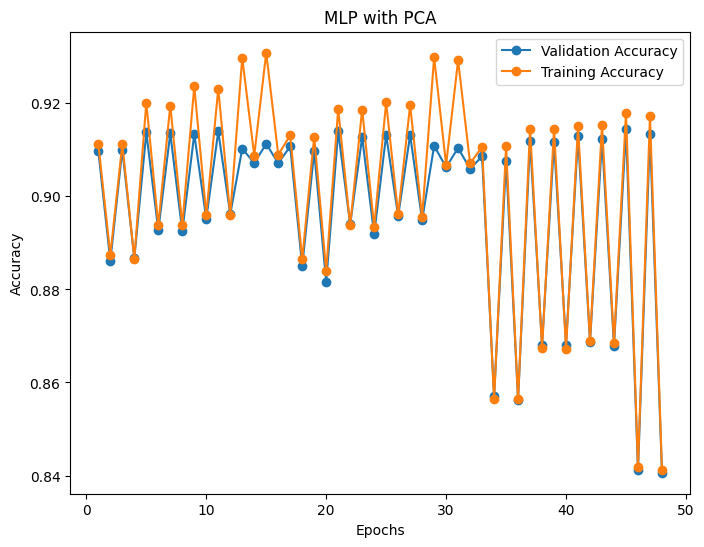

Best Hyperparameters for MLP with PCA: {'activation': 'logistic', 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
MLP with PCA Results:
Training Accuracy: 0.9186088203657224
Training Macro F1: 0.9185214199975741
Training Micro F1: 0.9186088203657224
Training Confusion Matrix: [[2307    0  371    0    8   12   91]
 [   0 2789    0    0    0    0    0]
 [ 167    0 2550    0   42    3   27]
 [   0    0    0 2525   15   62  187]
 [   8    0   35   20 2674    0   52]
 [  12    0    1   26    0 2665   85]
 [  19    0    6  229   54   57 2424]]
Test Accuracy: 0.9015429831006613
Test Macro F1: 0.910771543216628
Test Micro F1: 0.9015429831006613
Test Confusion Matrix: [[204   0  35   0   1   4  10]
 [  0 102   6   0   0   0   0]
 [  5   0 302   0   4   0   3]
 [  0   0   0 642   4  14  71]
 [  0   0  10   1 389   0   6]
 [  0   0   0   6   0 377  13]
 [  4   0   1  50  10  10 438]]


In [48]:
mlp_pca = MLPClassifier(max_iter=200)

grid_mlp_pca = GridSearchCV(mlp_pca, param_grid, cv=kfold, n_jobs=-1, 
                            scoring=make_scorer(accuracy_score, greater_is_better=True), 
                            return_train_score=True)

grid_mlp_pca.fit(X_pca, y_resampled)

# Plot accuracy vs epochs
plot_accuracy_vs_epochs(grid_mlp_pca, "MLP with PCA")

# Best hyperparameters
print("Best Hyperparameters for MLP with PCA:", grid_mlp_pca.best_params_)

# Re-train with the best parameters
best_mlp_pca = grid_mlp_pca.best_estimator_

# Evaluate
mlp_pca_results = evaluate_model(best_mlp_pca, X_pca, y_resampled, X_test_pca, y_test)

# Display results
print("MLP with PCA Results:")
for k, v in mlp_pca_results.items():
    print(f"{k}: {v}")

In [49]:
# MLP with LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_selected, y_resampled)
X_test_lda = lda.transform(X_test_selected)

mlp_lda = MLPClassifier(max_iter=200)

grid_mlp_lda = GridSearchCV(mlp_lda, param_grid, cv=kfold, n_jobs=-1, 
                            scoring=make_scorer(accuracy_score, greater_is_better=True), 
                            return_train_score=True)

grid_mlp_lda.fit(X_lda, y_resampled)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(10,), (50,), (100,),
                                                (100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'sgd']},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'))

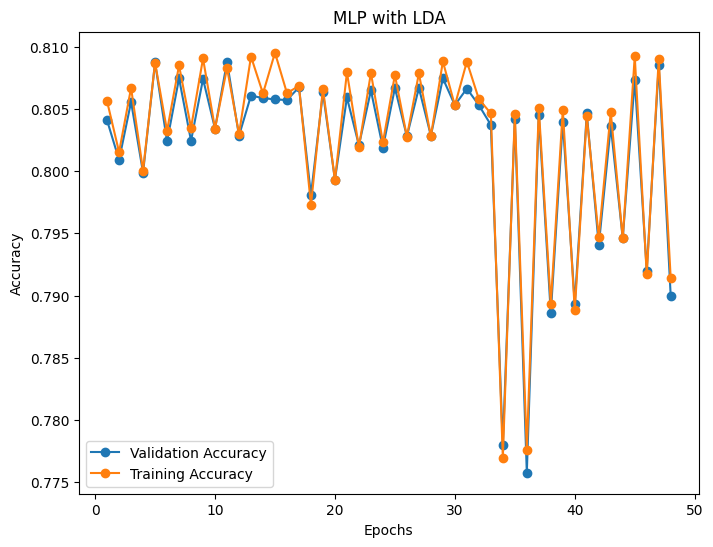

Best Hyperparameters for MLP with LDA: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLP with LDA Results:
Training Accuracy: 0.8097628438252318
Training Macro F1: 0.8109143232959611
Training Micro F1: 0.8097628438252318
Training Confusion Matrix: [[1938    0  406  193   12   14  226]
 [   0 2789    0    0    0    0    0]
 [ 593    1 2077    8   68    3   39]
 [ 314    0    6 2109    3   11  346]
 [  19    0   46   22 2469  148   85]
 [  20    0    8   18  229 2115  399]
 [  57    0    2  245   56  117 2312]]
Test Accuracy: 0.8196179279941219
Test Macro F1: 0.8341806423393041
Test Micro F1: 0.8196179279941219
Test Confusion Matrix: [[188   0  28   7   3   1  27]
 [  0 106   2   0   0   0   0]
 [ 49   0 253   0   8   0   4]
 [ 95   0   2 541   2   2  89]
 [  1   0   4   2 383   7   9]
 [  0   0   0   3  24 315  54]
 [  3   0   0  45   9  11 445]]


In [50]:
# Plot accuracy vs epochs
plot_accuracy_vs_epochs(grid_mlp_lda, "MLP with LDA")

# Best hyperparameters
print("Best Hyperparameters for MLP with LDA:", grid_mlp_lda.best_params_)

# Re-train with the best parameters
best_mlp_lda = grid_mlp_lda.best_estimator_

# Evaluate
mlp_lda_results = evaluate_model(best_mlp_lda, X_lda, y_resampled, X_test_lda, y_test)

# Display results
print("MLP with LDA Results:")
for k, v in mlp_lda_results.items():
    print(f"{k}: {v}")

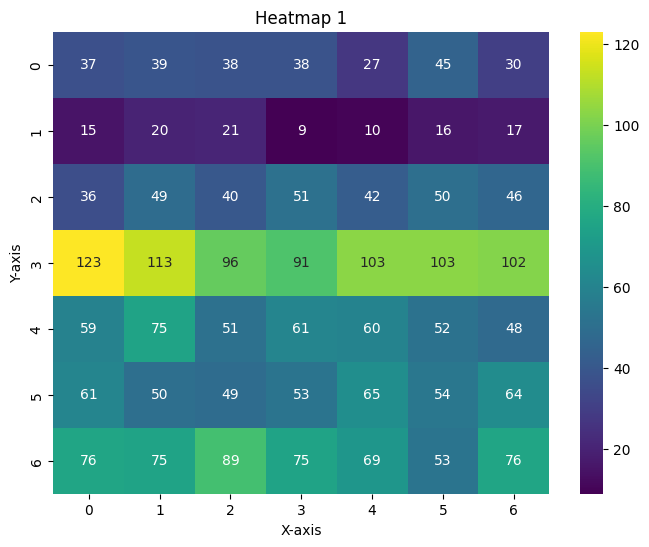

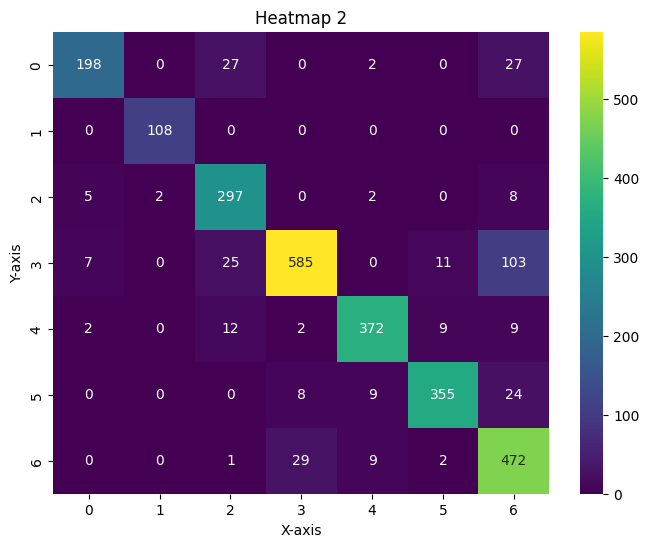

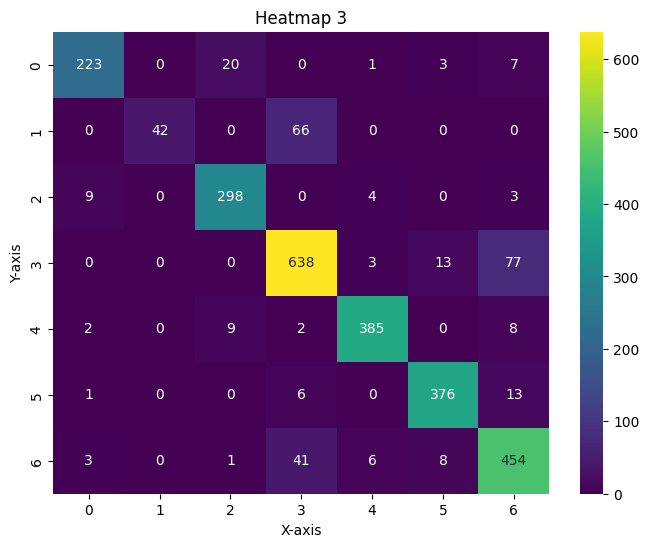

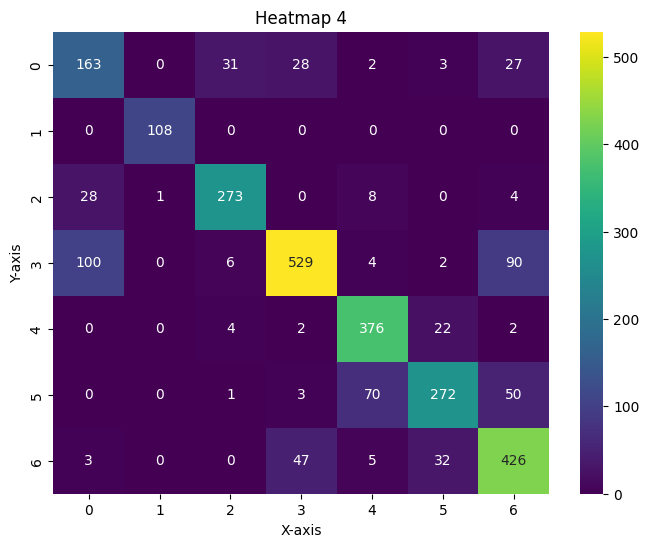

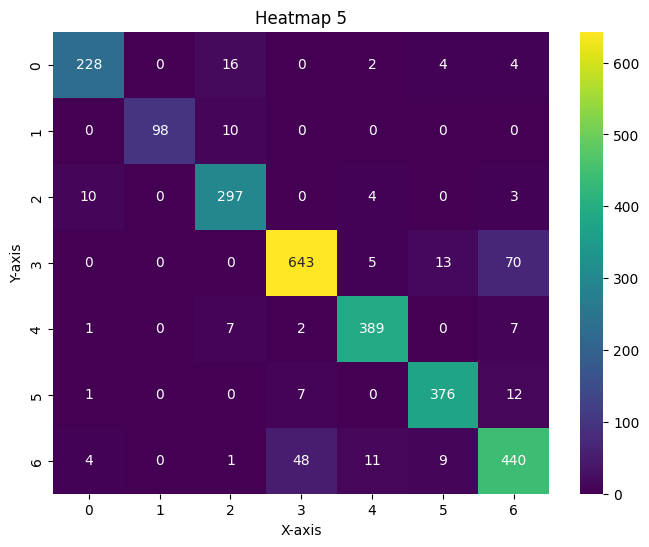

In [51]:
# Define the data
data = [
    np.array([
        [37, 39, 38, 38, 27, 45, 30],
        [15, 20, 21, 9, 10, 16, 17],
        [36, 49, 40, 51, 42, 50, 46],
        [123, 113, 96, 91, 103, 103, 102],
        [59, 75, 51, 61, 60, 52, 48],
        [61, 50, 49, 53, 65, 54, 64],
        [76, 75, 89, 75, 69, 53, 76]
    ]),
    np.array([
        [198, 0, 27, 0, 2, 0, 27],
        [0, 108, 0, 0, 0, 0, 0],
        [5, 2, 297, 0, 2, 0, 8],
        [7, 0, 25, 585, 0, 11, 103],
        [2, 0, 12, 2, 372, 9, 9],
        [0, 0, 0, 8, 9, 355, 24],
        [0, 0, 1, 29, 9, 2, 472]
    ]),
    np.array([
        [223, 0, 20, 0, 1, 3, 7],
        [0, 42, 0, 66, 0, 0, 0],
        [9, 0, 298, 0, 4, 0, 3],
        [0, 0, 0, 638, 3, 13, 77],
        [2, 0, 9, 2, 385, 0, 8],
        [1, 0, 0, 6, 0, 376, 13],
        [3, 0, 1, 41, 6, 8, 454]
    ]),
    np.array([
        [163, 0, 31, 28, 2, 3, 27],
        [0, 108, 0, 0, 0, 0, 0],
        [28, 1, 273, 0, 8, 0, 4],
        [100, 0, 6, 529, 4, 2, 90],
        [0, 0, 4, 2, 376, 22, 2],
        [0, 0, 1, 3, 70, 272, 50],
        [3, 0, 0, 47, 5, 32, 426]
    ]),
    np.array([
        [228, 0, 16, 0, 2, 4, 4],
        [0, 98, 10, 0, 0, 0, 0],
        [10, 0, 297, 0, 4, 0, 3],
        [0, 0, 0, 643, 5, 13, 70],
        [1, 0, 7, 2, 389, 0, 7],
        [1, 0, 0, 7, 0, 376, 12],
        [4, 0, 1, 48, 11, 9, 440]
    ])
]

# Plotting the heatmaps
for i, d in enumerate(data, start=1):
    plt.figure(figsize=(8, 6))
    sns.heatmap(d, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Heatmap {i}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
